### 0. stylegan encoding

- github:    
https://github.com/omertov/encoder4editing

- colab : https://colab.research.google.com/github/omertov/encoder4editing/blob/main/notebooks/inference_playground.ipynb

### e4e setup, run once only!

In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

# !git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

os.chdir('/content/drive/MyDrive/styleclip/encoder4editing')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.4 MB/s eta 0:03:49tcmalloc: large alloc 1147494400 bytes == 0x562b5abec000 @  0x7fca30a98615 0x562b57cc14cc 0x562b57da147a 0x562b57cc42ed 0x562b57db5e1d 0x562b57d37e99 0x562b57d329ee 0x562b57cc5bda 0x562b57d37d00 0x562b57d329ee 0x562b57cc5bda 0x562b57d34737 0x562b57db6c66 0x562b57d33daf 0x562b57db6c66 0x562b57d33daf 0x562b57db6c66 0x562b57d33daf 0x562b57cc6039 0x562b57d09409 0x562b57cc4c52 0x562b57d37c25 0x562b57d329ee 0x562b57cc5bda 0x562b57d34737 0x562b57d329ee 0x562b57cc5bda 0x562b57d33915 0x562b57cc5afa 0x562b57d33c0d 0x562b57d329ee
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:24tcmalloc: large alloc 1434370048 bytes == 0x562b9f242000 @  0x7fca30a98615 0x562b57cc14cc 0x562b57da147a 0x562b57cc42ed 0x562b57db5e1d 0x562b57d37e99 0x562b57d329ee 0x562b57cc5bda 0x562b57d37d00 0x562b57d329ee 0x562b57cc5bda 0x562b57d34737 0x

In [ ]:
# manually download
# 
# experiment_type = 'ffhq_encode'
# def get_download_model_command(file_id, file_name):
#     """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
#     current_directory = os.getcwd()
#     save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
#     url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
#     return url    

# MODEL_PATHS = {
#     "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
#     "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
#     "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
#     "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
# }

# path = MODEL_PATHS[experiment_type]
# download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

# !wget {download_command}

/content/drive/My: Operation not supported


# Input Image

In [ ]:
from google.colab import files
image_name = files.upload() # 파일 업로드 기능 실행

Saving photo2.jpeg to photo2.jpeg


In [ ]:
image_name = '/content/drive/MyDrive/styleclip/encoder4editing/photo2.jpeg'

In [ ]:
import os
os.chdir('/content/drive/MyDrive/styleclip/encoder4editing')
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_path": image_name
    }
    
}
experiment_type = 'ffhq_encode'

# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)

# e4e completion

In [ ]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


Aligned image has shape: (256, 256)


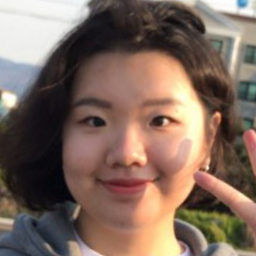

In [ ]:
image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

Inference took 0.1476 seconds.


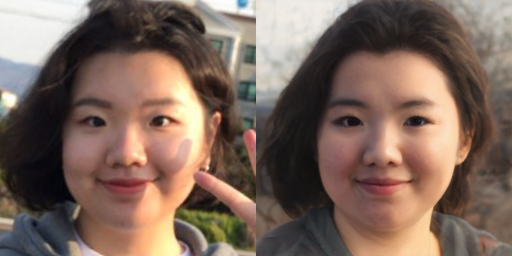

In [ ]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    tic = time.time()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

In [ ]:
torch.save(latents, 'latents.pt')

# StyleClip_Optimization

## Install

In [1]:
import os
os.chdir('/content/')

!git clone https://github.com/orpatashnik/StyleCLIP.git

os.chdir(f'./StyleCLIP')

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

Cloning into 'StyleCLIP'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 597 (delta 52), reused 109 (delta 41), pack-reused 461
Receiving objects: 100% (597/597), 164.45 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (188/188), done.
     |████████████████████████████████| 64 kB 2.1 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=b75e9e9b9e1eb29594aaa23b1901f5b3dc99a5d80b1b6960d209198008559c34
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-otf076q_
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-otf076q_
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369106 sha256=bf01cfcdce0021644659179149639e2fe395d6400ad09d27784756f9ee3efc1f
  Stored i

### Args

In [10]:
# args 입력 
experiment_type = 'edit' #@param ['edit', 'free_generation']

description = 'A person with purple hair' #@param {type:"string"}

latent_path = None #@param {type:"string"}

optimization_steps = 40 #@param {type:"number"}

l2_lambda = 0.008 #@param {type:"number"}

id_lambda = 0.005 #@param {type:"number"}

stylespace = False #@param {type:"boolean"}

create_video = True #@param {type:"boolean"}

use_seed = True #@param {type:"boolean"}

seed = 1 #@param {type:"boolean"}

In [2]:
# args 입력 __custom 
experiment_type = 'edit' #@param ['edit', 'free_generation']

description = 'A person with purple hair' #@param {type:"string"}

latent_path = '/content/drive/MyDrive/styleclip/encoder4editing/latents.pt' #@param {type:"string"}

optimization_steps = 40 #@param {type:"number"}

l2_lambda = 0.008 #@param {type:"number"}

id_lambda = 0.005 #@param {type:"number"}

stylespace = False #@param {type:"boolean"}

create_video = True #@param {type:"boolean"}

use_seed = True #@param {type:"boolean"}

seed = 1 #@param {type:"boolean"}

In [12]:
args = {
    "description": description,
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr_rampup": 0.05,
    "lr": 0.1,
    "step": optimization_steps,
    "mode": experiment_type,
    "l2_lambda": l2_lambda,
    "id_lambda": id_lambda,
    'work_in_stylespace': stylespace,
    "latent_path": latent_path,
    "truncation": 0.7,
    "save_intermediate_image_every": 1 if create_video else 20,
    "results_dir": "results",
    "ir_se50_weights": "model_ir_se50.pth"
}

from argparse import Namespace
args = Namespace(**args)

if use_seed:
  import torch
  torch.manual_seed(seed)

In [5]:
# stylegan2 generator 실행
import os
os.chdir('/content/StyleCLIP')
import torch
from models.stylegan2.model import Generator


g_ema = Generator(args.stylegan_size, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()

### 1.  text input 받아오기

In [6]:
os.makedirs(args.results_dir, exist_ok=True)

In [7]:
import os
import clip

##### text input 받아오기 #####
text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
text_inputs

tensor([[49406,   320,  2533,   593,  5496,  2225, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0')

### 2. latent initialize

Given a textual description,    
- one can both edit a given image,    
- or generate a random image that best fits to the description


In [13]:
##### initialize a random latent vector #####
# mean_latent 
mean_latent = g_ema.mean_latent(4096)

# latent path가 있을 때 (custom image -> latent path)
if args.latent_path:
    latent_code_init = torch.load(args.latent_path).cuda()

# args.mode == edit
# 정규분포에서 랜덤하게 벡터를 받아와 -> latent code 생성
elif args.mode == "edit":
    latent_code_init_not_trunc = torch.randn(1, 512).cuda()
    with torch.no_grad():
        _, latent_code_init, _ = g_ema([latent_code_init_not_trunc], return_latents=True,
                                    truncation=args.truncation, truncation_latent=mean_latent)
        
# args.mode == free generation
# generator의 mean latent를 받아옴 
else:
    latent_code_init = mean_latent.detach().clone().repeat(1, 18, 1)

# latent에 해당하는 원본 이미지
with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# w+ 가 아니라 S space에서 진행할 때 (논문 이후 추가된 사항)
if args.work_in_stylespace:
    with torch.no_grad():
        _, _, latent_code_init = g_ema([latent_code_init], input_is_latent=True, return_latents=True)
    latent = [s.detach().clone() for s in latent_code_init]
    for c, s in enumerate(latent):
        if c in STYLESPACE_INDICES_WITHOUT_TORGB:
            s.requires_grad = True

# latent vactor update -> yes
else:
    latent = latent_code_init.detach().clone()
    latent.requires_grad = True

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


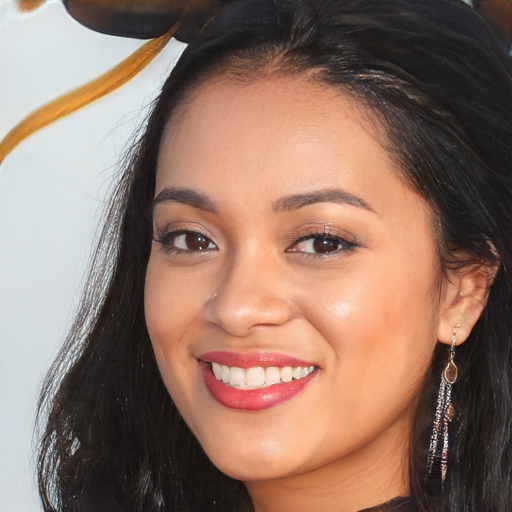

In [14]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = image.size
image.resize((h // 2, w // 2))

### 3. Loss 정의

In [15]:
# clip loss

import clip

class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

In [17]:
model, preprocess = clip.load("ViT-B/32", device="cuda")
upsample = torch.nn.Upsample(scale_factor=7)
avg_pool = torch.nn.AvgPool2d(kernel_size=32)
img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False, input_is_stylespace=args.work_in_stylespace)

image = avg_pool(upsample(img_gen))
model(image, text_inputs)

(tensor([[20.0625]], device='cuda:0', dtype=torch.float16,
        grad_fn=<MmBackward0>),
 tensor([[20.0625]], device='cuda:0', dtype=torch.float16, grad_fn=<TBackward0>))

In [18]:
model(image, text_inputs)

(tensor([[20.0625]], device='cuda:0', dtype=torch.float16,
        grad_fn=<MmBackward0>),
 tensor([[20.0625]], device='cuda:0', dtype=torch.float16, grad_fn=<TBackward0>))

In [19]:
clip_loss = CLIPLoss()
img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False, input_is_stylespace=args.work_in_stylespace)

c_loss = clip_loss(img_gen, text_inputs)
c_loss

tensor([[0.7993]], device='cuda:0', dtype=torch.float16,
       grad_fn=<RsubBackward1>)

In [23]:
c_loss.is_leaf

False

In [24]:
c_loss.requires_grad

True

In [25]:
c_loss.shape

torch.Size([1, 1])

In [26]:
c_loss.backward()

In [20]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=b89ebda82f7d8189c045c8d3ee36c6d1ff3e67aeca549cc69fbbd07f721aae8a
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [22]:
from torchviz import make_dot

make_dot(c_loss).render('clip_org', format = 'png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.549008 to fit
tcmalloc: large alloc 1187872768 bytes == 0x55dd9e5ca000 @  0x7faaa5017001 0x7faaa12ae1fa 0x7faaa12ae2ad 0x7faaa24396df 0x7faaa2930261 0x7faaa4dad468 0x7faaa4dafd53 0x55dd9aaf4092 0x7faaa4762bf7 0x55dd9aaf412a


'clip_org.png'

In [12]:
import sys
os.chdir('/content/StyleCLIP')
sys.path.append(".")
sys.path.append("..")

In [13]:
# ID Loss 
import torch
from torch import nn

from models.facial_recognition.model_irse import Backbone


class IDLoss(nn.Module):
    def __init__(self, opts):
        super(IDLoss, self).__init__()
        print('Loading ResNet ArcFace')
        self.facenet = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
        self.facenet.load_state_dict(torch.load(opts.ir_se50_weights))
        self.pool = torch.nn.AdaptiveAvgPool2d((256, 256))
        self.face_pool = torch.nn.AdaptiveAvgPool2d((112, 112))
        self.facenet.eval()
        self.facenet.cuda()
        self.opts = opts

    def extract_feats(self, x):
        if x.shape[2] != 256:
            x = self.pool(x)
        x = x[:, :, 35:223, 32:220]  # Crop interesting region
        x = self.face_pool(x)
        x_feats = self.facenet(x)
        return x_feats

    def forward(self, y_hat, y):
        n_samples = y.shape[0]
        y_feats = self.extract_feats(y)  # Otherwise use the feature from there
        y_hat_feats = self.extract_feats(y_hat)
        y_feats = y_feats.detach()
        loss = 0
        sim_improvement = 0
        count = 0
        for i in range(n_samples):
            diff_target = y_hat_feats[i].dot(y_feats[i])
            loss += 1 - diff_target
            count += 1

        return loss / count, sim_improvement / count

In [14]:
from torch import optim
clip_loss = CLIPLoss()
id_loss = IDLoss(args)

if args.work_in_stylespace:
    optimizer = optim.Adam(latent, lr=args.lr)
else:
    optimizer = optim.Adam([latent], lr=args.lr)

Loading ResNet ArcFace


### 4. 학습

In [15]:
# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

In [19]:
i_loss

tensor(0.2536, device='cuda:0', grad_fn=<DivBackward0>)

In [20]:
c_loss

tensor([[0.6396]], device='cuda:0', dtype=torch.float16,
       grad_fn=<RsubBackward1>)

In [21]:
loss

tensor([[0.7256]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddBackward0>)

In [16]:
import os
import math 

import torch
import torchvision
from torch import optim
from tqdm import tqdm

from mapper.training.train_utils import STYLESPACE_DIMENSIONS
from utils import ensure_checkpoint_exists

pbar = tqdm(range(args.step))

for i in pbar:
  # Adjust the learning rate
  t = i / args.step
  lr = get_lr(t, args.lr)
  optimizer.param_groups[0]["lr"] = lr

  # Generate an image using the latent vector
  img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False, input_is_stylespace=args.work_in_stylespace)

  # Loss 계산
  # CLIP 
  c_loss = clip_loss(img_gen, text_inputs)

  # ID 
  if args.id_lambda > 0:
      i_loss = id_loss(img_gen, img_orig)[0]
  else:
      i_loss = 0

  # L2
  if args.mode == "edit":
      if args.work_in_stylespace:
          l2_loss = sum([((latent_code_init[c] - latent[c]) ** 2).sum() for c in range(len(latent_code_init))])
      else:
          l2_loss = ((latent_code_init - latent) ** 2).sum()
      loss = c_loss + args.l2_lambda * l2_loss + args.id_lambda * i_loss
      # edit 모드일 경우 논문에 나온 full term loss 
  else:
      loss = c_loss
      # 아닐 경우, clip loss 만 

  # gradient descent -> update latent vector 
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # log 출력 
  pbar.set_description(
      (
          f"loss: {loss.item():.4f};"
      )
  )
  if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
      with torch.no_grad():
          img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False, input_is_stylespace=args.work_in_stylespace)

      torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.jpg", normalize=True, range=(-1, 1))

if args.mode == "edit":
  final_result = torch.cat([img_orig, img_gen])
else:
  final_result = img_gen

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
loss: 0.8110;:   0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
loss: 0.7256;: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


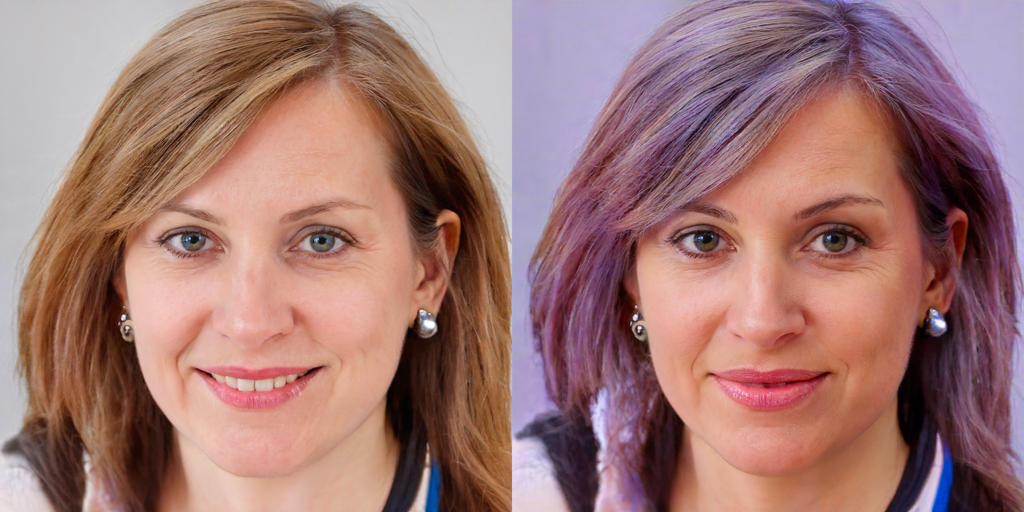

In [17]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

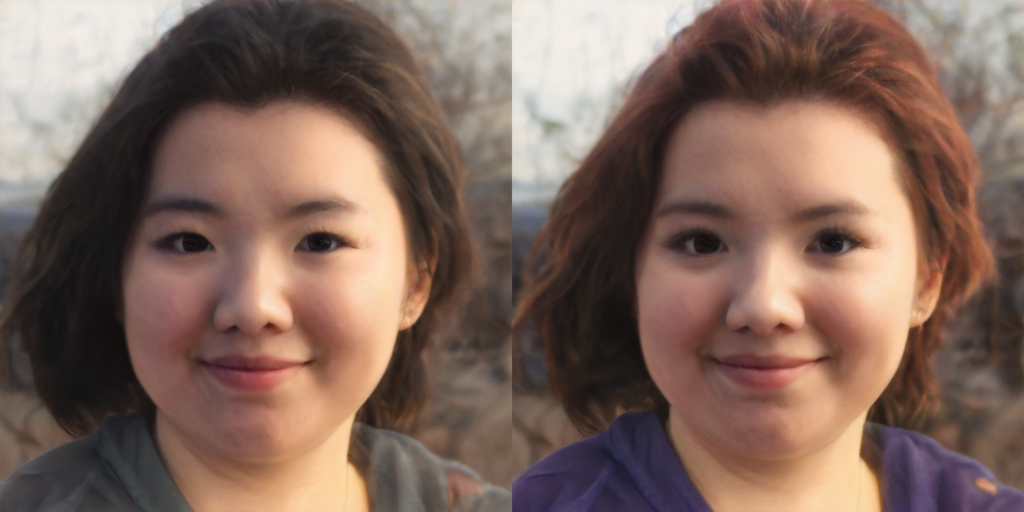

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

### 5. 함수화

In [ ]:
# original code 

def main(args):
    ensure_checkpoint_exists(args.ckpt)
    text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
    os.makedirs(args.results_dir, exist_ok=True)

    g_ema = Generator(args.stylegan_size, 512, 8)
    g_ema.load_state_dict(torch.load(args.ckpt)["g_ema"], strict=False)
    g_ema.eval()
    g_ema = g_ema.cuda()
    mean_latent = g_ema.mean_latent(4096)

    if args.latent_path:
        latent_code_init = torch.load(args.latent_path).cuda()
    elif args.mode == "edit":
        latent_code_init_not_trunc = torch.randn(1, 512).cuda()
        with torch.no_grad():
            _, latent_code_init, _ = g_ema([latent_code_init_not_trunc], return_latents=True,
                                        truncation=args.truncation, truncation_latent=mean_latent)
    else:
        latent_code_init = mean_latent.detach().clone().repeat(1, 18, 1)

    with torch.no_grad():
        img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

    if args.work_in_stylespace:
        with torch.no_grad():
            _, _, latent_code_init = g_ema([latent_code_init], input_is_latent=True, return_latents=True)
        latent = [s.detach().clone() for s in latent_code_init]
        for c, s in enumerate(latent):
            if c in STYLESPACE_INDICES_WITHOUT_TORGB:
                s.requires_grad = True
    else:
        latent = latent_code_init.detach().clone()
        latent.requires_grad = True

    clip_loss = CLIPLoss()
    id_loss = IDLoss(args)

    if args.work_in_stylespace:
        optimizer = optim.Adam(latent, lr=args.lr)
    else:
        optimizer = optim.Adam([latent], lr=args.lr)

    pbar = tqdm(range(args.step))

    for i in pbar:
        # Adjust the learning rate
        t = i / args.step
        lr = get_lr(t, args.lr)
        optimizer.param_groups[0]["lr"] = lr

        # Generate an image using the latent vector
        img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False, input_is_stylespace=args.work_in_stylespace)

        # Loss 계산
        # CLIP 
        c_loss = clip_loss(img_gen, text_inputs)

        # ID 
        if args.id_lambda > 0:
            i_loss = id_loss(img_gen, img_orig)[0]
        else:
            i_loss = 0

        # L2
        if args.mode == "edit":
            if args.work_in_stylespace:
                l2_loss = sum([((latent_code_init[c] - latent[c]) ** 2).sum() for c in range(len(latent_code_init))])
            else:
                l2_loss = ((latent_code_init - latent) ** 2).sum()
            loss = c_loss + args.l2_lambda * l2_loss + args.id_lambda * i_loss
            # edit 모드일 경우 논문에 나온 full term loss 
        else:
            loss = c_loss
            # 아닐 경우, clip loss 만 

        # gradient descent -> update latent vector 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log 출력 
        pbar.set_description(
            (
                f"loss: {loss.item():.4f};"
            )
        )
        if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
            with torch.no_grad():
                img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False, input_is_stylespace=args.work_in_stylespace)

            torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.jpg", normalize=True, range=(-1, 1))

    if args.mode == "edit":
        final_result = torch.cat([img_orig, img_gen])
    else:
        final_result = img_gen

    return final_result

In [ ]:
final_result = main(args)

Loading ResNet ArcFace


loss: 0.7847;:   0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
loss: 0.6826;: 100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


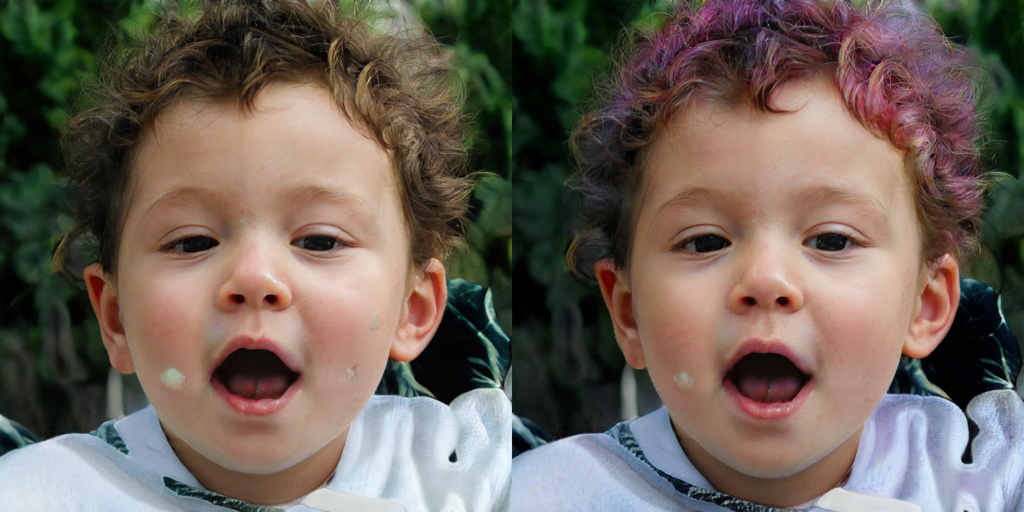

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))